In [159]:
import torch
import numpy as np
import pandas as pd
import ast
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [160]:
# Load dataset
train = pd.read_csv('../train_data_mod.csv')
test = pd.read_csv('../test_data_mod.csv')

In [161]:
train_mod = train.copy()
test_mod = test.copy()

-  instead of using the preprocessed text, we will use the original text applied.
- This is because BERT can learn context and relationships between words (including mispelled words), which makes it different from standard preprocessing techniques. 
- It also has it's own special tokenizer


#### Tokenizing the Text Feature

In [162]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [163]:
tokenizer_distil = BertTokenizer.from_pretrained('distilbert-base-cased')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [164]:
train_mod.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'preprocess_text',
       'bigram', 'trigram', 'pos', 'keyword_encoded', 'tweet_length',
       'punctuation_count'],
      dtype='object')

In [165]:
# drop unnecessary columns
drop_cols = ['keyword', 'location', 'preprocess_text','bigram','trigram', 'pos']


In [166]:
train_mod.drop(drop_cols, axis=1, inplace=True)
test_mod.drop(drop_cols, axis=1, inplace=True)

In [167]:
train_mod.columns

Index(['id', 'text', 'target', 'keyword_encoded', 'tweet_length',
       'punctuation_count'],
      dtype='object')

In [168]:
test_mod.columns

Index(['id', 'text', 'keyword_encoded', 'tweet_length', 'punctuation_count'], dtype='object')

In [169]:
numerical_features_columns = ['keyword_encoded', 'tweet_length', 'punctuation_count']

In [170]:
def max_length(text_column, tokenizer):
    max_len = 0
    for text in text_column:
        tokens = tokenizer.tokenize(text)
        # print(tokens)
        max_len = max(max_len, len(tokens))
    print("Max length: ", max_len, " tokens")
    return max_len

In [171]:
max_length(train_mod['text'], tokenizer)
max_length(test_mod['text'], tokenizer)

Max length:  104  tokens
Max length:  99  tokens


99

In [172]:
encoded_inputs =  tokenizer_distil(train_mod['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')


In [173]:
encoded_inputs_test = tokenizer_distil(test_mod['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

In [174]:
encoded_inputs_test.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [175]:
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

In [176]:
input_ids_test = encoded_inputs_test['input_ids']
attention_mask_test = encoded_inputs_test['attention_mask']

In [177]:
print(input_ids)
print(input_ids.shape)
print(attention_mask)
print(attention_mask.shape)

tensor([[  101,  3458,  9115,  ...,     0,     0,     0],
        [  101,  4089,  1783,  ...,     0,     0,     0],
        [  101,  1398,  3159,  ...,     0,     0,     0],
        ...,
        [  101, 26528,   119,  ...,     0,     0,     0],
        [  101,  3284, 11950,  ...,     0,     0,     0],
        [  101,  1109,  6372,  ...,     0,     0,     0]])
torch.Size([7613, 106])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([7613, 106])


In [178]:
print(input_ids_test)
print(input_ids_test.shape)
print(attention_mask_test)
print(attention_mask_test.shape)

tensor([[  101,  2066,  2171,  ...,     0,     0,     0],
        [  101, 23599,  1164,  ...,     0,     0,     0],
        [  101,  1175,  1110,  ...,     0,     0,     0],
        ...,
        [  101,  2565,  2800,  ...,     0,     0,     0],
        [  101, 22157,  2349,  ...,     0,     0,     0],
        [  101,   108,  1392,  ...,     0,     0,     0]])
torch.Size([3263, 101])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([3263, 101])


#### Standardizing the numerical features


In [179]:
from sklearn.preprocessing import StandardScaler

# Assuming you have a dataset df that contains both numerical and non-numerical features

# Separate the numerical and non-numerical features
numerical_features = train_mod[numerical_features_columns]
non_numerical_features = train_mod[['text','target']]

# Create an instance of the StandardScaler class
scaler = StandardScaler()

# Fit the scaler to the numerical features
scaler.fit(numerical_features)

# Transform the numerical features using the fitted scaler
numerical_features_scaled = scaler.transform(numerical_features)





In [180]:
numerical_features_scaled_test = scaler.transform(test_mod[numerical_features_columns])

In [181]:
# Convert scaled_numerical_features to a tensor
numerical_tensor = torch.tensor(numerical_features_scaled, dtype=torch.float32)

In [182]:
numerical_tensor_test = torch.tensor(numerical_features_scaled_test, dtype=torch.float32)

In [183]:
numerical_tensor

tensor([[ 1.1453, -0.9501, -1.2671],
        [ 1.1453, -1.8658, -1.2671],
        [ 1.1453,  0.9405, -0.8331],
        ...,
        [ 1.1453, -1.0682,  0.9028],
        [ 1.1453,  1.0587, -0.3992],
        [ 1.1453, -0.2116,  0.0348]])

In [184]:
numerical_tensor_test

tensor([[ 1.1453, -1.9840, -1.4841],
        [ 1.1453, -1.0978, -0.8331],
        [ 1.1453, -0.1525, -1.0501],
        ...,
        [ 1.1453, -1.3636, -0.3992],
        [ 1.1453, -1.0682,  0.0348],
        [ 1.1453, -0.9796, -0.8331]])

#### Getting the hidden states from BERT

In [185]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 2
dataset = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(dataset, batch_size=batch_size)


In [186]:
dataset_test = TensorDataset(input_ids_test, attention_mask_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

In [187]:
from transformers import BertModel

bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model.eval()

text_embeddings = []

with torch.no_grad():
    for batch_input_ids, batch_attention_masks in dataloader:
        outputs = bert_model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        text_embeddings.append(batch_embeddings)

# Concatenate all batch embeddings into a single tensor
text_embeddings = torch.cat(text_embeddings, dim=0)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyboardInterrupt: 

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model.eval()
text_embeddings_test = []

with torch.no_grad():
    for batch_input_ids, batch_attention_masks in dataloader_test:
        outputs = bert_model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        text_embeddings_test.append(batch_embeddings)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [ ]:
# Concatenate all batch embeddings into a single tensor
text_embeddings_test = torch.cat(text_embeddings_test, dim=0)

In [ ]:
combined_features_test = torch.cat([text_embeddings_test, numerical_tensor_test], dim=1)

In [ ]:
combined_features = torch.cat([text_embeddings, numerical_tensor], dim=1)

TypeError: expected Tensor as element 0 in argument 0, but got list

In [ ]:
combined_features.shape

(7613, 771)

#### Combined Neural Network class

In [ ]:
from torch import nn
from torch.optim import Adam
# Create a simple feed-forward neural network
class CombinedModel(nn.Module):
    def __init__(self, bert_output_size, num_numerical_features, num_classes):
        super(CombinedModel, self).__init__()
        self.layer = nn.Linear(bert_output_size + num_numerical_features, num_classes)
        

    def forward(self, x):
        return self.layer(x)





In [ ]:
class CombinedModelMoreHLs(nn.Module):
    def __init__(self, bert_output_size, num_numerical_features, num_classes, hidden_size=128, dropout_rate=0.5):
        super(CombinedModelMoreHLs, self).__init__()
        
        self.layer1 = nn.Linear(bert_output_size + num_numerical_features, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.activation1 = nn.ReLU()

        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.activation2 = nn.ReLU()

        # self.layer3 = nn.Linear(hidden_size, hidden_size)
        # self.dropout3 = nn.Dropout(dropout_rate)
        # self.activation3 = nn.ReLU()

        # self.layer4 = nn.Linear(hidden_size, hidden_size)
        # self.dropout4 = nn.Dropout(dropout_rate)
        # self.activation4 = nn.ReLU()

        self.output_layer = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.dropout1(x)
        x = self.activation1(x)

        x = self.layer2(x)
        x = self.dropout2(x)
        x = self.activation2(x)

        x = self.output_layer(x)
        return x

#### Convert to numpy for training

In [ ]:
combined_features = combined_features.numpy()

In [ ]:
combined_features

tensor([[ 0.2935, -0.0725, -0.1569,  ...,  1.1453, -0.9501, -1.2671],
        [ 0.2558,  0.1809, -0.1708,  ...,  1.1453, -1.8658, -1.2671],
        [ 0.0527,  0.0251,  0.1077,  ...,  1.1453,  0.9405, -0.8331],
        ...,
        [ 0.4800,  0.0919,  0.0373,  ...,  1.1453, -1.0682,  0.9028],
        [ 0.3759,  0.0696, -0.2249,  ...,  1.1453,  1.0587, -0.3992],
        [ 0.2824,  0.1017, -0.2784,  ...,  1.1453, -0.2116,  0.0348]])

In [ ]:
combined_features_test = combined_features_test.numpy()

In [ ]:
labels = train_mod['target']

In [ ]:
labels_numpy = labels.to_numpy()

In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


In [ ]:
import torch.optim as optim
import torch.nn.functional as F

def train_and_validate(train_dataloader, val_dataloader, len_val_dataset, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', lr=1e-3):
    # Replace with your custom model
    model = CombinedModel(bert_output_size=768, num_numerical_features=len(numerical_features_columns), num_classes=1)
    #model = CombinedModelMoreHLs(bert_output_size=768, num_numerical_features=len(numerical_features_columns), num_classes=1)
    model.to(device)

    print("Loaded Model to device")
    # Define the loss function and optimizer
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print("Initialized Loss and Optimizer")
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_loss = 0.0
        for batch_features, batch_labels in train_dataloader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(batch_features)
            loss = loss_fn(logits, batch_labels)

            # Backward pass
            loss.backward()

            # Update the model parameters
            optimizer.step()

            total_loss += loss.item()

        # Print the average training loss for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}')

        # Validation loop
        model.eval()
        total_val_loss = 0.0
        correct_predictions = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_dataloader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                # Forward pass
                logits = model(batch_features)
                loss = loss_fn(logits, batch_labels)

                # Calculate the number of correct predictions
                predictions = (logits > 0).float()
                correct_predictions += (predictions == batch_labels).sum().item()

                total_val_loss += loss.item()

        # Print the average validation loss and accuracy for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {total_val_loss / len(val_dataloader)}, Validation Accuracy: {correct_predictions / len_val_dataset}')
    return correct_predictions / len_val_dataset

In [ ]:
torch.tensor(combined_features[1])

tensor([ 2.5584e-01,  1.8094e-01, -1.7079e-01, -2.6513e-01, -4.3705e-01,
         5.8956e-02,  3.7884e-01,  1.1668e-01,  1.8814e-01, -1.3791e+00,
        -1.6295e-01,  3.5897e-01, -1.2012e-01, -1.8769e-01, -3.4638e-01,
         1.7986e-01,  6.7315e-02,  2.1108e-01,  2.7141e-01,  3.2946e-02,
        -4.3810e-02, -1.5269e-01,  5.6467e-01, -2.1989e-01,  3.0091e-01,
        -1.2909e-01,  1.6395e-01,  1.9878e-01, -1.8192e-01,  1.0246e-01,
         3.5770e-02,  2.9780e-02, -1.6495e-01,  2.9364e-01, -8.6084e-02,
         2.2865e-01, -1.2303e-01, -3.8921e-01,  3.9487e-02, -3.6750e-01,
        -3.9128e-01,  6.3324e-03,  3.2161e-01, -4.2472e-01,  3.1954e-03,
        -8.1638e-01,  4.3500e-02, -7.2592e-03, -2.6870e-01, -1.9641e-02,
        -7.7145e-02,  3.9884e-01,  5.6206e-01,  8.7265e-02,  3.3191e-01,
        -1.6589e-02,  1.7489e-02,  4.9950e-02, -4.0167e-01,  1.2930e-01,
         5.5091e-01,  6.6280e-03,  3.0802e-01, -9.7849e-02,  1.4942e-01,
        -1.5388e-02, -1.5098e-01,  4.6848e-01, -4.9

In [ ]:
type(combined_features)

numpy.ndarray

In [ ]:
type(labels)

pandas.core.series.Series

In [ ]:
new_data = torch.tensor(labels_numpy).reshape(-1,1)

In [ ]:
new_data.shape

torch.Size([7613, 1])

In [ ]:
new_data.type()

'torch.LongTensor'

#### Performed with CombinedModel

In [ ]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset))
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.51180837538064
Epoch 1/10, Validation Loss: 0.45885537131762627, Validation Accuracy: 0.8023637557452397
Epoch 2/10, Training Loss: 0.4391647931237233
Epoch 2/10, Validation Loss: 0.43369067538315087, Validation Accuracy: 0.8128693368351937
Epoch 3/10, Training Loss: 0.42095061489368674
Epoch 3/10, Validation Loss: 0.4212238465421175, Validation Accuracy: 0.8135259356533159
Epoch 4/10, Training Loss: 0.4164696148061377
Epoch 4/10, Validation Loss: 0.4188422065091695, Validation Accuracy: 0.8200919238345371
Epoch 5/10, Training Loss: 0.410205944512147
Epoch 5/10, Validation Loss: 0.4260024076122888, Validation Accuracy: 0.799080761654629
Epoch 6/10, Training Loss: 0.4071837898118915
Epoch 6/10, Validation Loss: 0.4176338863856505, Validation Accuracy: 0.8115561391989494
Epoch 7/10, Training Loss: 0.4051137128527083
Epoch 7/10, Validation Loss: 0.41878228931058764, Validation Accuracy: 0.8115561391989494
E

#### Performed on CombinedModel but with different epoch sizes

In [ ]:
epochs = [10, 20, 30, 40, 50, 60]
average_val_accuracy_dict = {}
for num_epoch in epochs:
    val_accuracies = []
    for train_idx, val_idx in skf.split(combined_features, labels):
        # Create TensorDatasets for the current fold
        train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

        # Create DataLoaders for the current fold
        train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

        # Train and validate your model for the current fold
        # Train and validate your model for the current fold and store the validation accuracy
        val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset), num_epoch)
        val_accuracies.append(val_accuracy)

    # Calculate the average validation accuracy across all folds
    average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    average_val_accuracy_dict[num_epoch] = average_val_accuracy
    print(f'Average Validation Accuracy: {average_val_accuracy}')
    print(f'Number of Epochs: {num_epoch}')


Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5061437223214177
Epoch 1/10, Validation Loss: 0.45030209285582545, Validation Accuracy: 0.8102429415627052
Epoch 2/10, Training Loss: 0.4370809833462939
Epoch 2/10, Validation Loss: 0.42884213364249124, Validation Accuracy: 0.8063033486539725
Epoch 3/10, Training Loss: 0.4221029051547758
Epoch 3/10, Validation Loss: 0.42262336943318085, Validation Accuracy: 0.8089297439264609
Epoch 4/10, Training Loss: 0.413288775567464
Epoch 4/10, Validation Loss: 0.4160624578673178, Validation Accuracy: 0.8154957321076822
Epoch 5/10, Training Loss: 0.41199049615640965
Epoch 5/10, Validation Loss: 0.4517123924851105, Validation Accuracy: 0.8056467498358503
Epoch 6/10, Training Loss: 0.4082318685381744
Epoch 6/10, Validation Loss: 0.42018501035362016, Validation Accuracy: 0.8063033486539725
Epoch 7/10, Training Loss: 0.4052742184518673
Epoch 7/10, Validation Loss: 0.42138958884237326, Validation Accuracy: 0.8207485226526

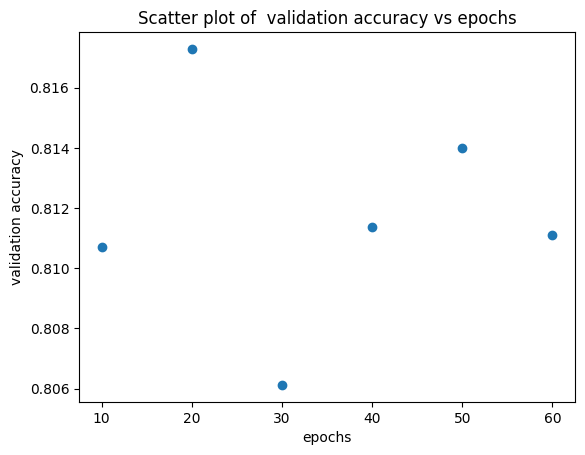

In [ ]:
# Using the average_val_accuracy_dict dictionary, plot a graph with number of epochs on x-axis and average validation accuracy on y-axis
import matplotlib.pyplot as plt

# Get the keys and values as separate lists
keys = list(average_val_accuracy_dict.keys())
values = list(average_val_accuracy_dict.values())

# Create a scatter plot
plt.scatter(keys, values)

# Add labels and a title
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.title('Scatter plot of  validation accuracy vs epochs')

# Display the plot
plt.show()


Based on this graph, we can see that epoch = 20 is the optimal parameter as it will give us a higher validation accuracy.

#### Performed with CombinedModelMoreHLs 2 layers

In [ ]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset))
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5212539559293763
Epoch 1/10, Validation Loss: 0.46027894185475654, Validation Accuracy: 0.7852921864740644
Epoch 2/10, Training Loss: 0.4625066204920528
Epoch 2/10, Validation Loss: 0.4172707948424117, Validation Accuracy: 0.8194353250164149
Epoch 3/10, Training Loss: 0.4483260045370718
Epoch 3/10, Validation Loss: 0.42814220780633505, Validation Accuracy: 0.804333552199606
Epoch 4/10, Training Loss: 0.4401030810329858
Epoch 4/10, Validation Loss: 0.42160315595138137, Validation Accuracy: 0.8161523309258043
Epoch 5/10, Training Loss: 0.43544550469814947
Epoch 5/10, Validation Loss: 0.43752659407702726, Validation Accuracy: 0.8095863427445831
Epoch 6/10, Training Loss: 0.4314051143864165
Epoch 6/10, Validation Loss: 0.4215296328808937, Validation Accuracy: 0.8194353250164149
Epoch 7/10, Training Loss: 0.42755096117059
Epoch 7/10, Validation Loss: 0.40877900235062337, Validation Accuracy: 0.818778726198292

#### Performed with CombinedModelMoreHLs 3 layers

In [ ]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset))
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5313310567729586
Epoch 1/10, Validation Loss: 0.43196900028988955, Validation Accuracy: 0.8122127380170716
Epoch 2/10, Training Loss: 0.4674192331046883
Epoch 2/10, Validation Loss: 0.4297476159945052, Validation Accuracy: 0.8102429415627052
Epoch 3/10, Training Loss: 0.4453050988552764
Epoch 3/10, Validation Loss: 0.42063600047252564, Validation Accuracy: 0.8168089297439265
Epoch 4/10, Training Loss: 0.445266618307807
Epoch 4/10, Validation Loss: 0.43529008583199835, Validation Accuracy: 0.8122127380170716
Epoch 5/10, Training Loss: 0.43418479615973987
Epoch 5/10, Validation Loss: 0.4165508486720592, Validation Accuracy: 0.8181221273801708
Epoch 6/10, Training Loss: 0.4391445624312078
Epoch 6/10, Validation Loss: 0.41631536039460393, Validation Accuracy: 0.8154957321076822
Epoch 7/10, Training Loss: 0.4288159793736584
Epoch 7/10, Validation Loss: 0.4162027304358195, Validation Accuracy: 0.81549573210768

#### Performed with CombinedModelMoreHLs 4 layers

In [ ]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset))
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')


Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5300837656839938
Epoch 1/10, Validation Loss: 0.460299644697243, Validation Accuracy: 0.7826657912015759
Epoch 2/10, Training Loss: 0.4611240529560354
Epoch 2/10, Validation Loss: 0.4158631797821422, Validation Accuracy: 0.8240315167432699
Epoch 3/10, Training Loss: 0.4545359466704014
Epoch 3/10, Validation Loss: 0.4325599910896174, Validation Accuracy: 0.8003939592908733
Epoch 4/10, Training Loss: 0.43679250963521127
Epoch 4/10, Validation Loss: 0.41214321422541794, Validation Accuracy: 0.8200919238345371
Epoch 5/10, Training Loss: 0.440173523608116
Epoch 5/10, Validation Loss: 0.43197188345491105, Validation Accuracy: 0.8076165462902167
Epoch 6/10, Training Loss: 0.4341056599303728
Epoch 6/10, Validation Loss: 0.4266218963561882, Validation Accuracy: 0.824688115561392
Epoch 7/10, Training Loss: 0.4283784716304519
Epoch 7/10, Validation Loss: 0.41462866819575817, Validation Accuracy: 0.8161523309258043


Adding more Hidden layers did not seem to significantly affect the validation accuracy, and is difficult to search for the optimal number of layers because of time constraints. We will use the original CombinedModel for our training.

#### Final Training of CombinedModel with Full Dataset

In [188]:
num_epoch = 20
# Create a TensorDataset for the entire dataset
full_dataset = TensorDataset(torch.tensor(combined_features), torch.tensor(labels_numpy.reshape(-1,1), dtype=torch.float32))

# Create a DataLoader for the entire dataset
full_dataloader = DataLoader(full_dataset, batch_size=8, shuffle=True)

# Train your model on the entire dataset (You can remove the validation loop from your train_and_validate function)
def train_full(train_dataloader, num_epochs=20, device='cuda' if torch.cuda.is_available() else 'cpu', lr=1e-3):
    # Replace with your custom model
    model = CombinedModel(bert_output_size=768, num_numerical_features=len(numerical_features_columns), num_classes=1)
    model.to(device)

    # Define the loss function and optimizer
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_loss = 0.0
        for batch_features, batch_labels in train_dataloader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(batch_features)
            loss = loss_fn(logits, batch_labels)

            # Backward pass
            loss.backward()

            # Update the model parameters
            optimizer.step()

            total_loss += loss.item()

        # Print the average training loss for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}')
    return model

# Train the model on the entire dataset
optimized_model = train_full(full_dataloader)


Epoch 1/20, Training Loss: 0.49409149911160727
Epoch 2/20, Training Loss: 0.43100062931473015
Epoch 3/20, Training Loss: 0.41683997809417356
Epoch 4/20, Training Loss: 0.4104725889658101
Epoch 5/20, Training Loss: 0.40978722899620024
Epoch 6/20, Training Loss: 0.4078459976428822
Epoch 7/20, Training Loss: 0.40195320415928837
Epoch 8/20, Training Loss: 0.4029730767747309
Epoch 9/20, Training Loss: 0.3991401407030262
Epoch 10/20, Training Loss: 0.3972657438007598
Epoch 11/20, Training Loss: 0.39512497596755747
Epoch 12/20, Training Loss: 0.39288129453242077
Epoch 13/20, Training Loss: 0.39348508504086305
Epoch 14/20, Training Loss: 0.3932994085661441
Epoch 15/20, Training Loss: 0.38916287017093987
Epoch 16/20, Training Loss: 0.388913738963922
Epoch 17/20, Training Loss: 0.3883396950472115
Epoch 18/20, Training Loss: 0.38732523281526354
Epoch 19/20, Training Loss: 0.38658176070204425
Epoch 20/20, Training Loss: 0.3863579233278747


Apply on Test Dataset

In [227]:
# Assuming your test data is a numpy array
test_combined_features = combined_features_test
test_combined_features_tensor = torch.tensor(combined_features_test, dtype=torch.float32)
optimized_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Move the model and test features to the appropriate device
optimized_model.to(device)
test_combined_features_tensor = test_combined_features_tensor.to(device)

# Perform a forward pass through the model to obtain predictions
with torch.no_grad():
    logits = optimized_model(test_combined_features_tensor)

# Process the predictions to get the final predicted targets
# If it's a binary classification problem, you can apply a threshold and convert the output to binary labels (0 or 1)
threshold = 0
predicted_targets = (logits > threshold).float().cpu().numpy()

# If it's a multi-class problem, you can apply a softmax function and get the class with the highest probability
# predicted_targets = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()

print(predicted_targets)


[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [228]:
predicted_targets = predicted_targets.astype(int)
df = pd.DataFrame(predicted_targets, columns=['target'])
df = pd.concat([ test['id'],df], axis=1)

In [229]:
df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [231]:
df.to_csv('test_results/BERT_CombinedNN.csv', index=False)